In [37]:
!pip install torchsummary

In [38]:
import glob
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.utils.tensorboard import SummaryWriter

import torchvision.models as models

from torchsummary import summary

import albumentations as A
from albumentations.pytorch import ToTensorV2

import numpy as np
import xml.etree.ElementTree as ET

from copy import deepcopy

from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [40]:
root_dir = '/kaggle/input/stanford-dogs-dataset'
img_dir = '/images/Images/'
annot_dir = '/annotations/Annotation/'

In [41]:
import os

labels_map = {}
for i, item in enumerate(os.listdir(root_dir + img_dir)):
    sub_folder = os.path.join(root_dir + img_dir, item)
    labels_map[sub_folder.split('-', maxsplit=3)[-1]] = i

In [42]:
def img_crop(annot_path, img):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    cropped_img = img[ymin:ymax, xmin:xmax]
    
    label = labels_map.get(species)

    return label, cropped_img

In [43]:
class DogsDataset(Dataset):
    def __init__(self, annot_dir, img_dir, transform=None):
        annot_dir = glob.glob(root_dir + annot_dir + '*/*')
        img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.annot_dir = sorted(annot_dir)
        self.img_dir = sorted(img_dir)
        self.transform = transform
        
    def __len__(self):
        return len(self.img_dir)
        
    def __getitem__(self, idx):
        annot_path = self.annot_dir[idx]
        img_path = self.img_dir[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label, img = img_crop(annot_path, img)
        if self.transform is not None:
            img = self.transform(image=img)
            img['label'] = label
            return img

        sample = {'image': img, 'label': label}
        return sample

In [44]:
transformer = A.Compose([
    A.Resize(224,224),
    A.Normalize(),
    ToTensorV2()
])

In [45]:
total_dataset = DogsDataset(annot_dir=annot_dir,
                           img_dir=img_dir,
                           transform=transformer)

In [46]:
total_label = [data['label'] for data in total_dataset]

trainset_idx, testset_idx = train_test_split(range(len(total_dataset)),
                test_size=0.2, random_state=42, shuffle=True, stratify=total_label)

In [47]:
train_set_ = Subset(total_dataset, trainset_idx)

train_label = [data['label'] for data in train_set_]

trainset_idx, validset_idx = train_test_split(range(len(trainset_idx)),
                test_size=0.2, random_state=42, shuffle=True, stratify=train_label)

In [48]:
train_set = Subset(train_set_, trainset_idx)
test_set = Subset(total_dataset, testset_idx)
valid_set = Subset(train_set_, validset_idx)

# 시각화

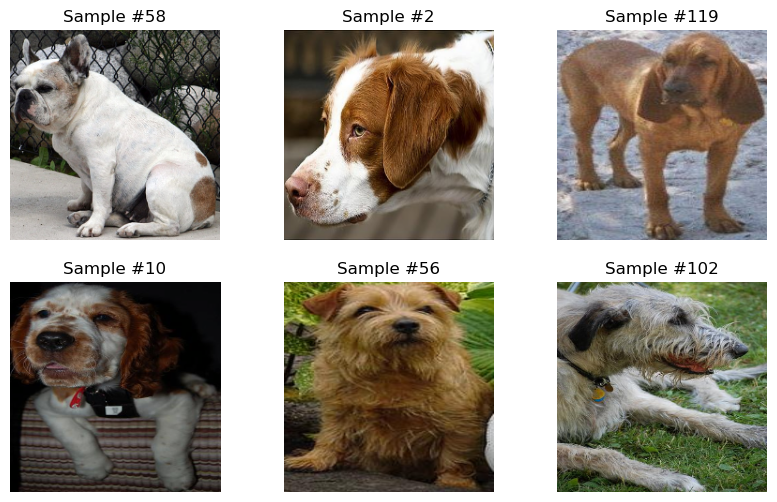

In [49]:
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
axes = axes.flatten()

for i in range(6):
    rand_i = np.random.randint(0, len(total_dataset))
    sample = total_dataset[rand_i]
    image = sample['image'].permute(1, 2, 0)
    label = sample['label']
    
    mean=torch.tensor([0.485, 0.456, 0.406]) 
    std=torch.tensor([0.229, 0.224, 0.225])
    image.mul_(std)
    image.add_(mean)
    
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title('Sample #{}'.format(label))

# 데이터 적재

In [50]:
batch_size = 32
trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [51]:
train_iter = iter(trainloader)
batch = next(train_iter)
batch['image'].size(), len(batch['label'])

(torch.Size([32, 3, 224, 224]), 32)

# 모델 생성

In [52]:
model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)

## 모델 변경

In [53]:
model.fc = nn.Linear(in_features=1024, out_features=120, bias=True)

In [54]:
for parameter in model.parameters():
    parameter.requires_grad = False

In [55]:
for parameter in model.fc.parameters():
    parameter.requires_grad=True

In [56]:
for parameter in model.parameters():
    print(parameter.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals

In [57]:
model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [58]:
out = model(batch['image'].to(device))
out.shape

torch.Size([32, 120])

In [59]:
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

In [60]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
       BasicConv2d-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
       BasicConv2d-7           [-1, 64, 56, 56]               0
            Conv2d-8          [-1, 192, 56, 56]         110,592
       BatchNorm2d-9          [-1, 192, 56, 56]             384
      BasicConv2d-10          [-1, 192, 56, 56]               0
        MaxPool2d-11          [-1, 192, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          12,288
      BatchNorm2d-13           [-1, 64, 28, 28]             128
      BasicConv2d-14           [-1, 64,

# 모델 학습

In [61]:
def validate(model, validloader, loss_fn):
    total = 0   
    correct = 0
    valid_loss = 0
    valid_accuracy = 0

  
    with torch.no_grad():
        for batch in validloader:
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)

            logit = model(images) 
            _, preds = torch.max(logit, 1)
            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            valid_loss += loss.item()

        valid_accuracy = correct / total
  
    return valid_loss, valid_accuracy

In [62]:
def train_loop(model, trainloader, loss_fn, epochs, optimizer):
    steps = 0
    steps_per_epoch = len(trainloader)
    min_loss = np.inf
    max_accuracy = -np.inf
    trigger = 0
    p = 10


    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for batch in tqdm(trainloader):
            images=batch['image'].to(device)
            labels=batch['label']
            labels = torch.Tensor(labels).to(device)
            
            steps+=1
                      
            predict = model(images)
            loss = loss_fn(predict, labels)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            train_loss += loss.item()

            if (steps % steps_per_epoch) == 0:
                model.eval()
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)    
                
                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                    'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                    'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                    'Valid Accuracy : {:.3f}'.format(valid_accuracy))

                if (valid_loss < min_loss) and (valid_accuracy >= max_accuracy):
                    print('save ckpt')
                    min_loss = valid_loss
                    max_accuracy = valid_accuracy

                    best_model = deepcopy(model)
                    torch.save(best_model.state_dict(), 'best_ckpt_transfer_google32_lr001_wp.pth')

                
                # --- early stopping --- #
                if valid_loss > min_loss:
                    print('----trigger----', trigger+1)
                    trigger += 1
                    if trigger > p:
                        print('Early Stopping')
                        print('training loop is finished')

                        return 
                else:
                    trigger = 0
                    min_loss = valid_loss
                    
                scheduler.step(valid_loss)


In [63]:
epochs = 150
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)

100%|██████████| 412/412 [01:49<00:00,  3.75it/s]


Epoch : 1/150....... Train Loss : 2.279 Valid Loss : 1.173 Valid Accuracy : 0.717
save ckpt


100%|██████████| 412/412 [01:50<00:00,  3.71it/s]


Epoch : 2/150....... Train Loss : 1.112 Valid Loss : 0.982 Valid Accuracy : 0.718
save ckpt


100%|██████████| 412/412 [01:48<00:00,  3.81it/s]


Epoch : 3/150....... Train Loss : 0.917 Valid Loss : 0.867 Valid Accuracy : 0.743
save ckpt


100%|██████████| 412/412 [01:47<00:00,  3.84it/s]


Epoch : 4/150....... Train Loss : 0.809 Valid Loss : 0.824 Valid Accuracy : 0.750
save ckpt


100%|██████████| 412/412 [01:45<00:00,  3.92it/s]


Epoch : 5/150....... Train Loss : 0.728 Valid Loss : 0.822 Valid Accuracy : 0.755
save ckpt


100%|██████████| 412/412 [01:43<00:00,  3.96it/s]


Epoch : 6/150....... Train Loss : 0.679 Valid Loss : 0.778 Valid Accuracy : 0.759
save ckpt


100%|██████████| 412/412 [01:45<00:00,  3.91it/s]


Epoch : 7/150....... Train Loss : 0.629 Valid Loss : 0.805 Valid Accuracy : 0.753
----trigger---- 1


100%|██████████| 412/412 [01:42<00:00,  4.03it/s]


Epoch : 8/150....... Train Loss : 0.598 Valid Loss : 0.795 Valid Accuracy : 0.759
----trigger---- 2


100%|██████████| 412/412 [01:42<00:00,  4.01it/s]


Epoch : 9/150....... Train Loss : 0.568 Valid Loss : 0.773 Valid Accuracy : 0.766
save ckpt


100%|██████████| 412/412 [01:43<00:00,  4.00it/s]


Epoch : 10/150....... Train Loss : 0.546 Valid Loss : 0.797 Valid Accuracy : 0.753
----trigger---- 1


100%|██████████| 412/412 [01:43<00:00,  4.00it/s]


Epoch : 11/150....... Train Loss : 0.529 Valid Loss : 0.809 Valid Accuracy : 0.752
----trigger---- 2


100%|██████████| 412/412 [01:42<00:00,  4.00it/s]


Epoch : 12/150....... Train Loss : 0.499 Valid Loss : 0.797 Valid Accuracy : 0.761
----trigger---- 3


100%|██████████| 412/412 [01:42<00:00,  4.02it/s]


Epoch : 13/150....... Train Loss : 0.483 Valid Loss : 0.854 Valid Accuracy : 0.748
----trigger---- 4
Epoch 00013: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 412/412 [01:44<00:00,  3.95it/s]


Epoch : 14/150....... Train Loss : 0.406 Valid Loss : 0.770 Valid Accuracy : 0.769
save ckpt


100%|██████████| 412/412 [01:44<00:00,  3.96it/s]


Epoch : 15/150....... Train Loss : 0.398 Valid Loss : 0.757 Valid Accuracy : 0.769
save ckpt


100%|██████████| 412/412 [01:44<00:00,  3.95it/s]


Epoch : 16/150....... Train Loss : 0.394 Valid Loss : 0.756 Valid Accuracy : 0.771
save ckpt


100%|██████████| 412/412 [01:50<00:00,  3.72it/s]


Epoch : 17/150....... Train Loss : 0.394 Valid Loss : 0.751 Valid Accuracy : 0.775
save ckpt


100%|██████████| 412/412 [01:52<00:00,  3.67it/s]


Epoch : 18/150....... Train Loss : 0.393 Valid Loss : 0.767 Valid Accuracy : 0.767
----trigger---- 1


100%|██████████| 412/412 [01:52<00:00,  3.66it/s]


Epoch : 19/150....... Train Loss : 0.392 Valid Loss : 0.739 Valid Accuracy : 0.776
save ckpt


100%|██████████| 412/412 [01:47<00:00,  3.84it/s]


Epoch : 20/150....... Train Loss : 0.378 Valid Loss : 0.744 Valid Accuracy : 0.770
----trigger---- 1


100%|██████████| 412/412 [01:43<00:00,  3.99it/s]


Epoch : 21/150....... Train Loss : 0.388 Valid Loss : 0.747 Valid Accuracy : 0.773
----trigger---- 2


100%|██████████| 412/412 [01:42<00:00,  4.03it/s]


Epoch : 22/150....... Train Loss : 0.379 Valid Loss : 0.760 Valid Accuracy : 0.769
----trigger---- 3


100%|██████████| 412/412 [01:43<00:00,  3.98it/s]


Epoch : 23/150....... Train Loss : 0.378 Valid Loss : 0.742 Valid Accuracy : 0.771
----trigger---- 4
Epoch 00023: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 412/412 [01:44<00:00,  3.96it/s]


Epoch : 24/150....... Train Loss : 0.372 Valid Loss : 0.740 Valid Accuracy : 0.775
----trigger---- 5


100%|██████████| 412/412 [01:44<00:00,  3.93it/s]


Epoch : 25/150....... Train Loss : 0.371 Valid Loss : 0.753 Valid Accuracy : 0.769
----trigger---- 6


100%|██████████| 412/412 [01:43<00:00,  3.96it/s]


Epoch : 26/150....... Train Loss : 0.371 Valid Loss : 0.766 Valid Accuracy : 0.767
----trigger---- 7


100%|██████████| 412/412 [01:43<00:00,  3.99it/s]


Epoch : 27/150....... Train Loss : 0.370 Valid Loss : 0.758 Valid Accuracy : 0.770
----trigger---- 8
Epoch 00027: reducing learning rate of group 0 to 1.0000e-06.


100%|██████████| 412/412 [01:42<00:00,  4.02it/s]


Epoch : 28/150....... Train Loss : 0.374 Valid Loss : 0.740 Valid Accuracy : 0.772
----trigger---- 9


100%|██████████| 412/412 [01:44<00:00,  3.96it/s]


Epoch : 29/150....... Train Loss : 0.367 Valid Loss : 0.744 Valid Accuracy : 0.773
----trigger---- 10


100%|█████████▉| 411/412 [01:43<00:00,  3.96it/s]

Epoch : 30/150....... Train Loss : 0.369 Valid Loss : 0.743 Valid Accuracy : 0.772
----trigger---- 11
Early Stopping
training loop is finished
CPU times: user 47min 9s, sys: 6min 42s, total: 53min 52s
Wall time: 52min 38s


# 모델 예측

In [64]:
test_iter = iter(testloader)

batch = next(test_iter)

images, labels = batch['image'].to(device), batch['label'].to(device)
print(images.size(), labels.size())

rnd_idx = 3
print(images[rnd_idx].shape, labels[rnd_idx])

torch.Size([32, 3, 224, 224]) torch.Size([32])
torch.Size([3, 224, 224]) tensor(47, device='cuda:0')


In [65]:
model.eval()
with torch.no_grad():
    logit = model(images[rnd_idx].unsqueeze(0))
pred = logit.max(dim=1)[1]
print(pred == labels[rnd_idx])

tensor([True], device='cuda:0')


pred: tensor([47], device='cuda:0') labels: tensor(47, device='cuda:0')
torch.Size([224, 224, 3])


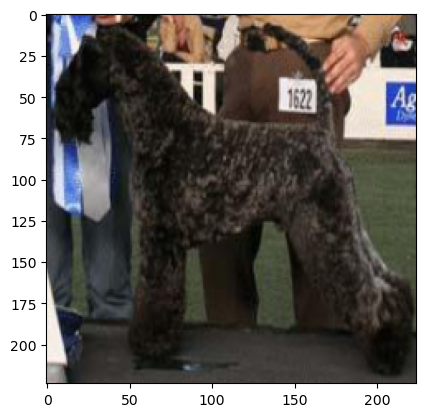

In [66]:
print("pred:", pred, "labels:", labels[rnd_idx])

images = images[rnd_idx].permute(1, 2, 0).cpu()
mean=torch.tensor([0.485, 0.456, 0.406]) 
std=torch.tensor([0.229, 0.224, 0.225])
images.mul_(std)
images.add_(mean)
print(images.shape)
plt.imshow(images)

In [67]:
def evaluation(model, testloader, loss_fn):
    total = 0   
    correct = 0
    test_loss = 0
    test_accuracy = 0

    with torch.no_grad():
        for batch in testloader:
            images, labels = batch['image'].to(device), batch['label'].to(device)

            logit = model(images)
            _, preds = torch.max(logit, 1)

            correct += int((preds == labels).sum())
            total += labels.shape[0]

            loss = loss_fn(logit, labels)
            test_loss += loss.item()
            
        test_accuracy = correct / total
   
        print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
            'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn)  

Test Loss : 0.804 Test Accuracy : 0.766


# 모델 저장

In [68]:
torch.save(model.state_dict(), 'last_ckpt_transfer_google32_lr001_wp.pth')

In [69]:
last_state_dict = torch.load('last_ckpt_transfer_google32_lr001_wp.pth')

In [70]:
last_model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
last_model.fc = nn.Linear(in_features=1024, out_features=120)
last_model.to(device)
last_model.get_parameter = last_model.load_state_dict(last_state_dict)

In [71]:
last_model.eval()
evaluation(last_model, testloader, loss_fn)  

Test Loss : 0.804 Test Accuracy : 0.766


In [72]:
best_state_dict = torch.load('best_ckpt_transfer_google32_lr001_wp.pth')

In [73]:
best_model = models.googlenet(weights=models.GoogLeNet_Weights.DEFAULT)
best_model.fc = nn.Linear(in_features=1024, out_features=120)
best_model.to(device)
best_model.get_parameter = best_model.load_state_dict(best_state_dict)

In [74]:
best_model.eval()
evaluation(best_model, testloader, loss_fn)

Test Loss : 0.798 Test Accuracy : 0.766
